# Anchovy eDNA vs Acoustic Strength

In [8]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import glob
import seaborn as sns
from scipy import stats

#For illustrator import:
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

#Directory for saving Figures
plot_dir = '../figures/Anchovy_Acoustic/'
print(plot_dir)

levels = ['Kingdom', 'Phylum', 'Class', 'Order', 'Family', 'Genus', 'Species']


../figures/Anchovy_Acoustic/


### Import Filtered Data (from previous Jupyter notebook)

In [3]:
#location of data:
directory = '../data/filtered_seq_data/'
markers = ['12S']

otus= []
taxas=[]
metas=[]
for marker in markers:
    print('XXXXXX    ',marker)
    df = pd.read_csv(directory+'CN19S_'+marker+'_otu_Filtered.csv')
    df = df.rename(columns={'Unnamed: 0':'ASV'})
    df.set_index('ASV', inplace=True)
    otus.append(df)
    print('Number samples in otu_table:', len(list(df)))
    df = pd.read_csv(directory+'CN19S_'+marker+'_meta_Filtered.csv')
    df.set_index('sample_name', inplace=True)
    #date handling
    print(list(df))
    df['eventDate'] = pd.to_datetime(df['eventDate'])
    df['month'] = df['eventDate'].dt.month
    metas.append(df)
    print('Number samples in metadata table:', len(df.index))
    df = pd.read_csv(directory+'CN19S_'+marker+'_taxa_Filtered.csv')
    df = df.rename(columns={'Unnamed: 0':'ASV'})
    df.set_index('ASV', inplace=True)
    print('Number ASVs in taxa table:', len(df.index))
    taxas.append(df)
taxas[0].head()

XXXXXX     12S
Number samples in otu_table: 223
['FilterID', 'target_gene', 'PlateID', 'library', 'local_time', 'time_label', 'SAMPLING_cruise', 'depth', 'SAMPLING_platform', 'SC', 'ESP', 'SAMPLING_station_number', 'SAMPLING_station', 'SAMPLING_bottle', 'decimalLongitude', 'decimalLatitude', 'sample_type', 'Plates', 'Markers', 'Status', 'Dewar_name', 'Sampling_method', 'replicate', 'SAMPLING_rdepth', 'project_name', 'nitrate', 'fluor', 'density', 'pressure', 'minimumDepthInMeters', 'maximumDepthInMeters', 'start_GMT', 'end_GMT', 'temp', 'salinity', 'sigmat', 'spice', 'diss_oxygen', 'PAR (umol/s/m2)', 'altitude', 'chlorophyll', 'bbp470 (count)', 'bbp650 (count)', 'SAMPLING_project', 'ESP_name', 'diel', 'month', 'day', 'hour', 'eventDate']
Number samples in metadata table: 223
Number ASVs in taxa table: 450


,Kingdom,Phylum,Class,Order,Family,Genus,Species
ASV,,,,,,,
ASV_1,Eukaryota,Chordata,Actinopteri,Clupeiformes,Engraulidae,Engraulis,Engraulis mordax
ASV_4,Eukaryota,Chordata,Actinopteri,Gadiformes,Macrouridae,Coryphaenoides,unassigned
ASV_8,Eukaryota,Chordata,Actinopteri,Argentiniformes,Bathylagidae,Bathylagus,Bathylagus pacificus
ASV_12,Eukaryota,Chordata,Actinopteri,Argentiniformes,Bathylagidae,Leuroglossus,Leuroglossus schmidti
ASV_13,Eukaryota,Chordata,Actinopteri,Gadiformes,Merlucciidae,Merluccius,Merluccius productus


### Import Acoustic Data

In [21]:
# CTD
file = '../data/DEIMOS/WF_eDNA_acoustics.csv'
df = pd.read_csv(file)
df.set_index('FilterID', inplace=True)
DEIM = df.copy()
print(list(df))
df.head()

['Average sampled energy', 'Percent total sampled']


,Average sampled energy,Percent total sampled
FilterID,,
CN19Sc03_10_eDNA,3.992650e-04,1.05
CN19Sc03_09_eDNA,2.234680e-07,0.00
CN19Sc03_07_eDNA,5.868500e-07,0.00
CN19Sc03_05_eDNA,4.356320e-07,0.00
CN19Sc03_04_eDNA,7.256560e-07,0.00


In [23]:
# LRAUV
file = '../data/DEIMOS/LRAUV_eDNA_acoustics.csv'
df = pd.read_csv(file)
df.set_index('FilterID', inplace=True)
print(list(df))
#check this interpretation is correct with Kelly
df = df.rename(columns={'Sampled depth acoustic energy':'Average sampled energy',
                       'Percent of total energy samples':'Percent total sampled'})
df = df[['Average sampled energy', 'Percent total sampled']]
DEIM_LRAUV = df.copy()
df.head()


['sample', 'Sampled depth acoustic energy', 'Total acoustic energy', 'Percent of total energy samples', 'Unnamed: 5']


,Average sampled energy,Percent total sampled
FilterID,,
CN19SESPMV1_SC05_eDNA,7.595200e-07,0.15
CN19SESPMV1_SC04_eDNA,1.164360e-05,0.06
CN19SESPMV1_SC03_eDNA,3.934580e-05,6.21
CN19SESPMV1_SC58_eDNA,1.665825e-03,33.40
CN19SESPKOA_SC58_eDNA,9.196670e-05,18.59


### Merge Acoustic and eDNA information

In [88]:
#eDNA reads - just Anchovy 
print(markers[0])
levels = list(taxas[0])
df = pd.concat([otus[0], taxas[0]], axis=1)
#sum all fish and shark reads
df = df.loc[df['Genus'].isin(['Engraulis'])==True]
df = df.groupby('Genus').sum()

df = df.T
# get cast, bottle info to match up samples
df = pd.concat([df, metas[0][['depth', 'FilterID', 'SAMPLING_station_number', 'SAMPLING_bottle', 'SAMPLING_station']]], axis=1)
#remove bongo samples
df = df.loc[df['FilterID'].str.contains('Bongo|bongo')==False]
df = df.sort_values(['SAMPLING_station_number', 'SAMPLING_bottle'])

df['SC'] = df.FilterID.str.split('_').str[1]
df.loc[df['FilterID'].str.contains('SC')==False, 'SC'] = np.nan

df['SAMPLING_bottle'] = df['SAMPLING_bottle'].astype(float)
df['SAMPLING_station_number'] = df['SAMPLING_station_number'].astype(float)

df.loc[df['FilterID'].str.contains('MV1')==True, 'ESP'] = 'MV1'
df.loc[df['FilterID'].str.contains('KOA')==True, 'ESP'] = 'KOA'

df = df.reset_index().set_index(['SAMPLING_station_number', 'SAMPLING_bottle','SC', 'ESP'])
eDNA = df.copy()
eDNA

12S


sample_name  \
SAMPLING_station_number SAMPLING_bottle SC   ESP                             
1.0                     12.0            NaN  NaN       CN19Sc01_12_eDNA_JJ   
2.0                     12.0            NaN  NaN       CN19Sc02_12_eDNA_JJ   
3.0                     1.0             NaN  NaN        CN19Sc03_1_eDNA_JJ   
                        3.0             NaN  NaN        CN19Sc03_3_eDNA_JJ   
                        4.0             NaN  NaN        CN19Sc03_4_eDNA_JJ   
...                                                                    ...   
NaN                     NaN             SC53 MV1  CN19SESPMV1_SC53_eDNA_AT   
                                        SC52 MV1  CN19SESPMV1_SC52_eDNA_AT   
                                        SC51 MV1  CN19SESPMV1_SC51_eDNA_AT   
                                        SC50 MV1  CN19SESPMV1_SC50_eDNA_AT   
                                        SC49 MV1  CN19SESPMV1_SC49_eDNA_AT   

                                                  Engraulis     depth  \
SAMPLING_station_number SAMPLING_bottle SC   ESP                        
1.0                     12.0            NaN  NaN      23171    0.0000   
2.0                     12.0            NaN  NaN      10743    0.0000   
3.0                     1.0             NaN  NaN         33  600.0000   
                        3.0             NaN  NaN         60  400.0000   
                        4.0             NaN  NaN       8378  300.0000   
...                                                     ...       ...   
NaN                     NaN             SC53 MV1     153010   47.5118   
                                        SC52 MV1      47660   37.5310   
                                        SC51 MV1        398  212.4281   
                                        SC50 MV1      54320   32.4372   
                                        SC49 MV1        246  207.4803   

                                                               FilterID  \
SAMPLING_station_number SAMPLING_bottle SC   ESP                          
1.0                     12.0            NaN  NaN       CN19Sc01_12_eDNA   
2.0                     12.0            NaN  NaN       CN19Sc02_12_eDNA   
3.0                     1.0             NaN  NaN       CN19Sc03_01_eDNA   
                        3.0             NaN  NaN       CN19Sc03_03_eDNA   
                        4.0             NaN  NaN       CN19Sc03_04_eDNA   
...                                                                 ...   
NaN                     NaN             SC53 MV1  CN19SESPMV1_SC53_eDNA   
                                        SC52 MV1  CN19SESPMV1_SC52_eDNA   
                                        SC51 MV1  CN19SESPMV1_SC51_eDNA   
                                        SC50 MV1  CN19SESPMV1_SC50_eDNA   
                                        SC49 MV1  CN19SESPMV1_SC49_eDNA   

                                                 SAMPLING_station  
SAMPLING_station_number SAMPLING_bottle SC   ESP                   
1.0                     12.0            NaN  NaN               C1  
2.0                     12.0            NaN  NaN         MOORING1  
3.0                     1.0             NaN  NaN             MARS  
                        3.0             NaN  NaN             MARS  
                        4.0             NaN  NaN             MARS  
...                                                           ...  
NaN                     NaN             SC53 MV1              NaN  
                                        SC52 MV1              NaN  
                                        SC51 MV1              NaN  
                                        SC50 MV1              NaN  
                                        SC49 MV1              NaN  

[217 rows x 5 columns]

In [105]:
#Join DEIMOS data
df1 = pd.concat([DEIM, DEIM_LRAUV], axis=0)

df1['SAMPLING_station_number'] = df1.index.str.split('c').str[1].str.split('_').str[0].astype(float)
df1['SAMPLING_bottle'] = df1.index.str.split('_').str[1]

#nan out ESP samples
df1.loc[df1['SAMPLING_bottle'].str.contains('SC')==True, 'SAMPLING_bottle'] = np.nan
df1['SAMPLING_bottle'] = df1['SAMPLING_bottle'].astype(float)
df1 = df1.reset_index()
print(list(df1))
df1 = df1.rename(columns={'index':'FilterID'})
df1 = df1.loc[df1['FilterID'].str.contains('eDNA')==True]

df1['SC'] = df1.FilterID.str.split('_').str[1]
df1.loc[df1['FilterID'].str.contains('SC')==False, 'SC'] = np.nan
#get ESP ID
df1.loc[df1['FilterID'].str.contains('MV1')==True, 'ESP'] = 'MV1'
df1.loc[df1['FilterID'].str.contains('KOA')==True, 'ESP'] = 'KOA'


#check duplicates
#df1['dup'] = df1.duplicated(['SAMPLING_station_number', 'SAMPLING_bottle', 'SC', 'ESP'], keep=False)
#df1 = df1.loc[df1['dup']==True]

df1 = df1.set_index(['SAMPLING_station_number', 'SAMPLING_bottle', 'SC', 'ESP'])

df = pd.concat([eDNA,df1], axis=1)

#some samples not sequenced
df=df.loc[df['Engraulis'].isna()==False]
df.to_csv('/Users/kpitz/Documents/test.csv')
eDNA_Ac = df.copy()
df.head()

['FilterID', 'Average sampled energy', 'Percent total sampled', 'SAMPLING_station_number', 'SAMPLING_bottle']


sample_name  \
SAMPLING_station_number SAMPLING_bottle SC  ESP                        
1.0                     12.0            NaN NaN  CN19Sc01_12_eDNA_JJ   
2.0                     12.0            NaN NaN  CN19Sc02_12_eDNA_JJ   
3.0                     1.0             NaN NaN   CN19Sc03_1_eDNA_JJ   
                        3.0             NaN NaN   CN19Sc03_3_eDNA_JJ   
                        4.0             NaN NaN   CN19Sc03_4_eDNA_JJ   

                                                 Engraulis  depth  \
SAMPLING_station_number SAMPLING_bottle SC  ESP                     
1.0                     12.0            NaN NaN    23171.0    0.0   
2.0                     12.0            NaN NaN    10743.0    0.0   
3.0                     1.0             NaN NaN       33.0  600.0   
                        3.0             NaN NaN       60.0  400.0   
                        4.0             NaN NaN     8378.0  300.0   

                                                         FilterID  \
SAMPLING_station_number SAMPLING_bottle SC  ESP                     
1.0                     12.0            NaN NaN  CN19Sc01_12_eDNA   
2.0                     12.0            NaN NaN  CN19Sc02_12_eDNA   
3.0                     1.0             NaN NaN  CN19Sc03_01_eDNA   
                        3.0             NaN NaN  CN19Sc03_03_eDNA   
                        4.0             NaN NaN  CN19Sc03_04_eDNA   

                                                SAMPLING_station  \
SAMPLING_station_number SAMPLING_bottle SC  ESP                    
1.0                     12.0            NaN NaN               C1   
2.0                     12.0            NaN NaN         MOORING1   
3.0                     1.0             NaN NaN             MARS   
                        3.0             NaN NaN             MARS   
                        4.0             NaN NaN             MARS   

                                                         FilterID  \
SAMPLING_station_number SAMPLING_bottle SC  ESP                     
1.0                     12.0            NaN NaN               NaN   
2.0                     12.0            NaN NaN               NaN   
3.0                     1.0             NaN NaN  CN19Sc03_01_eDNA   
                        3.0             NaN NaN  CN19Sc03_03_eDNA   
                        4.0             NaN NaN  CN19Sc03_04_eDNA   

                                                 Average sampled energy  \
SAMPLING_station_number SAMPLING_bottle SC  ESP                           
1.0                     12.0            NaN NaN                     NaN   
2.0                     12.0            NaN NaN                     NaN   
3.0                     1.0             NaN NaN            7.566200e-09   
                        3.0             NaN NaN            3.789950e-07   
                        4.0             NaN NaN            7.256560e-07   

                                                 Percent total sampled  
SAMPLING_station_number SAMPLING_bottle SC  ESP                         
1.0                     12.0            NaN NaN                    NaN  
2.0                     12.0            NaN NaN                    NaN  
3.0                     1.0             NaN NaN                    0.0  
                        3.0             NaN NaN                    0.0  
                        4.0             NaN NaN                    0.0

# Compare Acoustic Data to Anchovy eDNA Reads

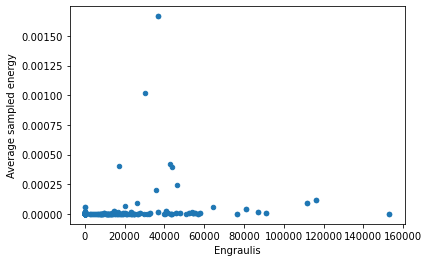

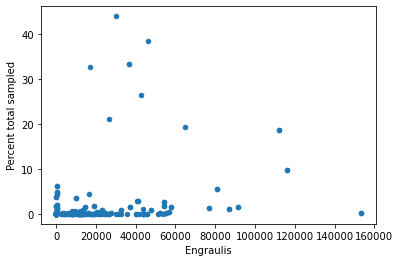

sample_name  \
SAMPLING_station_number SAMPLING_bottle SC  ESP                        
1.0                     12.0            NaN NaN  CN19Sc01_12_eDNA_JJ   
2.0                     12.0            NaN NaN  CN19Sc02_12_eDNA_JJ   
3.0                     1.0             NaN NaN   CN19Sc03_1_eDNA_JJ   
                        3.0             NaN NaN   CN19Sc03_3_eDNA_JJ   
                        4.0             NaN NaN   CN19Sc03_4_eDNA_JJ   

                                                 Engraulis  depth  \
SAMPLING_station_number SAMPLING_bottle SC  ESP                     
1.0                     12.0            NaN NaN    23171.0    0.0   
2.0                     12.0            NaN NaN    10743.0    0.0   
3.0                     1.0             NaN NaN       33.0  600.0   
                        3.0             NaN NaN       60.0  400.0   
                        4.0             NaN NaN     8378.0  300.0   

                                                         FilterID  \
SAMPLING_station_number SAMPLING_bottle SC  ESP                     
1.0                     12.0            NaN NaN  CN19Sc01_12_eDNA   
2.0                     12.0            NaN NaN  CN19Sc02_12_eDNA   
3.0                     1.0             NaN NaN  CN19Sc03_01_eDNA   
                        3.0             NaN NaN  CN19Sc03_03_eDNA   
                        4.0             NaN NaN  CN19Sc03_04_eDNA   

                                                SAMPLING_station  \
SAMPLING_station_number SAMPLING_bottle SC  ESP                    
1.0                     12.0            NaN NaN               C1   
2.0                     12.0            NaN NaN         MOORING1   
3.0                     1.0             NaN NaN             MARS   
                        3.0             NaN NaN             MARS   
                        4.0             NaN NaN             MARS   

                                                         FilterID  \
SAMPLING_station_number SAMPLING_bottle SC  ESP                     
1.0                     12.0            NaN NaN               NaN   
2.0                     12.0            NaN NaN               NaN   
3.0                     1.0             NaN NaN  CN19Sc03_01_eDNA   
                        3.0             NaN NaN  CN19Sc03_03_eDNA   
                        4.0             NaN NaN  CN19Sc03_04_eDNA   

                                                 Average sampled energy  \
SAMPLING_station_number SAMPLING_bottle SC  ESP                           
1.0                     12.0            NaN NaN                     NaN   
2.0                     12.0            NaN NaN                     NaN   
3.0                     1.0             NaN NaN            7.566200e-09   
                        3.0             NaN NaN            3.789950e-07   
                        4.0             NaN NaN            7.256560e-07   

                                                 Percent total sampled  
SAMPLING_station_number SAMPLING_bottle SC  ESP                         
1.0                     12.0            NaN NaN                    NaN  
2.0                     12.0            NaN NaN                    NaN  
3.0                     1.0             NaN NaN                    0.0  
                        3.0             NaN NaN                    0.0  
                        4.0             NaN NaN                    0.0

In [98]:
# Direct Plot
df = eDNA_Ac.copy()

df.plot(kind='scatter', y='Average sampled energy', x='Engraulis' )
plt.show()

df.plot(kind='scatter', y='Percent total sampled', x='Engraulis' )
plt.show()
df.head()

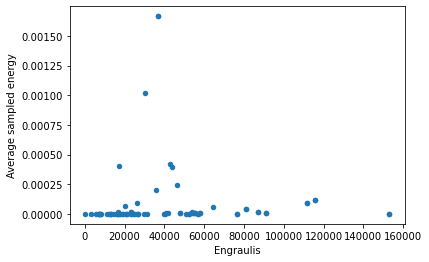

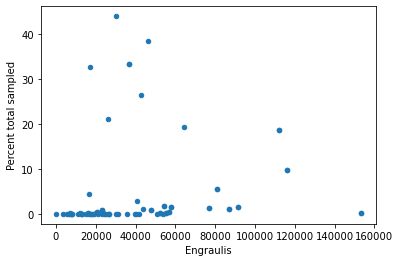

sample_name  \
SAMPLING_station_number SAMPLING_bottle SC  ESP                        
3.0                     9.0             NaN NaN   CN19Sc03_9_eDNA_JJ   
                        10.0            NaN NaN  CN19Sc03_10_eDNA_JJ   
                        12.0            NaN NaN  CN19Sc03_12_eDNA_JJ   
10.0                    9.0             NaN NaN   CN19Sc10_9_eDNA_JJ   
                        10.0            NaN NaN  CN19Sc10_10_eDNA_JJ   

                                                 Engraulis  depth  \
SAMPLING_station_number SAMPLING_bottle SC  ESP                     
3.0                     9.0             NaN NaN    23279.0   80.0   
                        10.0            NaN NaN    43759.0   40.0   
                        12.0            NaN NaN    20108.0    0.0   
10.0                    9.0             NaN NaN     7353.0   80.0   
                        10.0            NaN NaN    39924.0   50.0   

                                                         FilterID  \
SAMPLING_station_number SAMPLING_bottle SC  ESP                     
3.0                     9.0             NaN NaN  CN19Sc03_09_eDNA   
                        10.0            NaN NaN  CN19Sc03_10_eDNA   
                        12.0            NaN NaN  CN19Sc03_12_eDNA   
10.0                    9.0             NaN NaN  CN19Sc10_09_eDNA   
                        10.0            NaN NaN  CN19Sc10_10_eDNA   

                                                SAMPLING_station  \
SAMPLING_station_number SAMPLING_bottle SC  ESP                    
3.0                     9.0             NaN NaN             MARS   
                        10.0            NaN NaN             MARS   
                        12.0            NaN NaN             MARS   
10.0                    9.0             NaN NaN             MARS   
                        10.0            NaN NaN             MARS   

                                                         FilterID  \
SAMPLING_station_number SAMPLING_bottle SC  ESP                     
3.0                     9.0             NaN NaN  CN19Sc03_09_eDNA   
                        10.0            NaN NaN  CN19Sc03_10_eDNA   
                        12.0            NaN NaN  CN19Sc03_12_eDNA   
10.0                    9.0             NaN NaN  CN19Sc10_09_eDNA   
                        10.0            NaN NaN  CN19Sc10_10_eDNA   

                                                 Average sampled energy  \
SAMPLING_station_number SAMPLING_bottle SC  ESP                           
3.0                     9.0             NaN NaN            2.234680e-07   
                        10.0            NaN NaN            3.992650e-04   
                        12.0            NaN NaN            7.076640e-05   
10.0                    9.0             NaN NaN            4.208490e-07   
                        10.0            NaN NaN            5.235520e-07   

                                                 Percent total sampled  
SAMPLING_station_number SAMPLING_bottle SC  ESP                         
3.0                     9.0             NaN NaN                   0.00  
                        10.0            NaN NaN                   1.05  
                        12.0            NaN NaN                   0.19  
10.0                    9.0             NaN NaN                   0.03  
                        10.0            NaN NaN                   0.04

In [104]:
#Top 100m
df = eDNA_Ac.copy()
df = df.loc[df['depth']<=100]

df = df.loc[df['Average sampled energy']>0]
df = df.loc[df['Engraulis']>0]

df.plot(kind='scatter', y='Average sampled energy', x='Engraulis' )
plt.show()

df.plot(kind='scatter', y='Percent total sampled', x='Engraulis' )
plt.show()
df.head()

### Log scale and linear regression

R-squared: 0.195242
../figures/Anchovy_Acoustic/CN19S_12S_avgDEIMOS_linres_logavg_everything.pdf


<ipython-input-150-b4e8a036583c>:34: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "papertype" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(filename,dpi=None, facecolor='w', edgecolor='w',
<ipython-input-150-b4e8a036583c>:34: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(filename,dpi=None, facecolor='w', edgecolor='w',


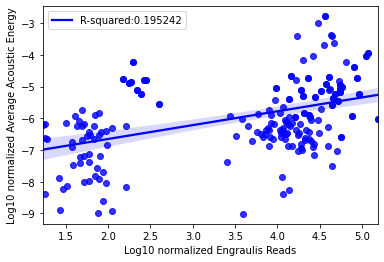

In [150]:
#Everything together

#####   log scale (reads + Ac)
df = eDNA_Ac.copy()
#remove 0 values?
df = df.loc[df['Average sampled energy']>0]
df = df.loc[df['Engraulis']>0]


df['lognorm_avg'] = np.log10(df['Average sampled energy'])
df['lognorm_chordata'] = np.log10(df['Engraulis'])
df = df.sort_values('lognorm_avg')
df = df.loc[df['lognorm_avg']!=0]
df = df.loc[df['lognorm_avg'].isna()==False]

# get coeffs of linear fit
slope, intercept, r_value, p_value, std_err = stats.linregress(df['lognorm_chordata'],df['lognorm_avg'])
res = stats.linregress(df['lognorm_chordata'],df['lognorm_avg'])
print(f"R-squared: {res.rvalue**2:.6f}")


# use line_kws to set line label for legend
ax = sns.regplot(x="lognorm_chordata", y="lognorm_avg", data=df, color='b', 
 line_kws={'label':f"R-squared:{res.rvalue**2:.6f}"})
# plot legend
ax.legend()

ax.set_xlabel('Log10 normalized Engraulis Reads')
ax.set_ylabel('Log10 normalized Average Acoustic Energy')

#save
filename=plot_dir +'CN19S_12S_avgDEIMOS_linres_logavg_everything.pdf'
print(filename)
plt.savefig(filename,dpi=None, facecolor='w', edgecolor='w',
        orientation='landscape', papertype=None, format=None,
        transparent=True, bbox_inches='tight', pad_inches=1,
        frameon=None)

plt.show()


### Just samples with >1000 reads to Anchovy

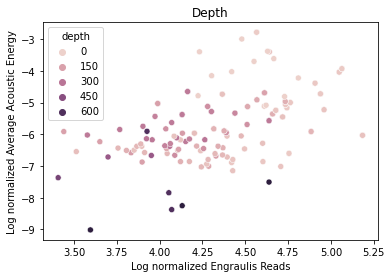

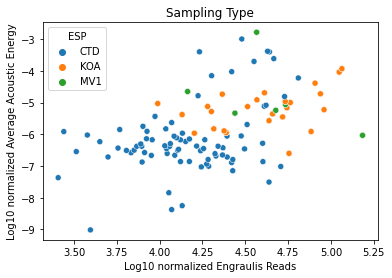

In [149]:
# only samples which detect >1000 reads of Anchovy

#####   log scale (reads + Ac)
df = eDNA_Ac.copy()
#remove 0 values?
df = df.loc[df['Average sampled energy']>0]
df = df.loc[df['Engraulis']>=1000]
#df = df.loc[df['depth']<100]

df['lognorm_avg'] = np.log10(df['Average sampled energy'])
df['lognorm_chordata'] = np.log10(df['Engraulis'])
df = df.sort_values('lognorm_avg')
df = df.loc[df['lognorm_avg']!=0]
df = df.loc[df['lognorm_avg'].isna()==False]

ax = sns.scatterplot(data=df,x="lognorm_chordata", y="lognorm_avg",hue='depth' )
ax.set_xlabel('Log normalized Engraulis Reads')
ax.set_ylabel('Log normalized Average Acoustic Energy')
ax.set_title('Depth')
plt.show()
df = df.reset_index()
df.loc[df['ESP'].isna()==True, 'ESP'] = 'CTD'
ax = sns.scatterplot(data=df,x="lognorm_chordata", y="lognorm_avg",hue='ESP' )
ax.set_xlabel('Log10 normalized Engraulis Reads')
ax.set_ylabel('Log10 normalized Average Acoustic Energy')
ax.set_title('Sampling Type')
plt.show()


R-squared: 0.240927
../figures/Anchovy_Acoustic/CN19S_12S_avgDEIMOS_linres_logavg_1000readsAnch.pdf


<ipython-input-148-7f8cae12e4ba>:32: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "papertype" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(filename,dpi=None, facecolor='w', edgecolor='w',
<ipython-input-148-7f8cae12e4ba>:32: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(filename,dpi=None, facecolor='w', edgecolor='w',


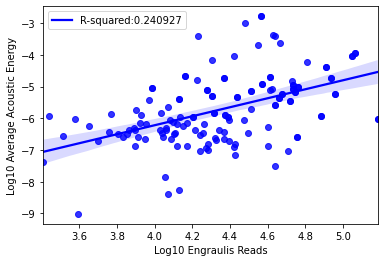

In [148]:
#####   log scale (reads + Ac)
df = eDNA_Ac.copy()
#remove 0 values?
df = df.loc[df['Average sampled energy']>0]
df = df.loc[df['Engraulis']>=1000]
#df = df.loc[df['depth']<100]

df['lognorm_avg'] = np.log10(df['Average sampled energy'])
df['lognorm_chordata'] = np.log10(df['Engraulis'])
df = df.sort_values('lognorm_avg')
df = df.loc[df['lognorm_avg']!=0]
df = df.loc[df['lognorm_avg'].isna()==False]

# get coeffs of linear fit
slope, intercept, r_value, p_value, std_err = stats.linregress(df['lognorm_chordata'],df['lognorm_avg'])
res = stats.linregress(df['lognorm_chordata'],df['lognorm_avg'])
print(f"R-squared: {res.rvalue**2:.6f}")


# use line_kws to set line label for legend
ax = sns.regplot(x="lognorm_chordata", y="lognorm_avg", data=df, color='b', 
 line_kws={'label':f"R-squared:{res.rvalue**2:.6f}"})
# plot legend
ax.legend()

ax.set_xlabel('Log10 Engraulis Reads')
ax.set_ylabel('Log10 Average Acoustic Energy')

#save
filename=plot_dir +'CN19S_12S_avgDEIMOS_linres_logavg_1000readsAnch.pdf'
print(filename)
plt.savefig(filename,dpi=None, facecolor='w', edgecolor='w',
        orientation='landscape', papertype=None, format=None,
        transparent=True, bbox_inches='tight', pad_inches=1,
        frameon=None)

plt.show()

### Look at proportion of Anchovy reads
- Or scale 0 to 1 independently on each plate (account for plate effects)

In [133]:
#eDNA reads - just Anchovy 
print(markers[0])
levels = list(taxas[0])
#make compositional
df = otus[0].copy()
df = df.T
cols = list(df)
df['tot'] = df.sum(axis=1)
for i in cols:
    df[i] = df[i]/df['tot']*100
df = df.drop('tot', axis=1)
df = df.T
df = pd.concat([df, taxas[0]], axis=1)
#sum all fish and shark reads
df = df.loc[df['Genus'].isin(['Engraulis'])==True]
df = df.groupby('Genus').sum()

df = df.T
# get cast, bottle info to match up samples
df = pd.concat([df, metas[0][['depth', 'FilterID', 'SAMPLING_station_number', 'SAMPLING_bottle', 'SAMPLING_station']]], axis=1)
#remove bongo samples
df = df.loc[df['FilterID'].str.contains('Bongo|bongo')==False]
df = df.sort_values(['SAMPLING_station_number', 'SAMPLING_bottle'])

df['SC'] = df.FilterID.str.split('_').str[1]
df.loc[df['FilterID'].str.contains('SC')==False, 'SC'] = np.nan

df['SAMPLING_bottle'] = df['SAMPLING_bottle'].astype(float)
df['SAMPLING_station_number'] = df['SAMPLING_station_number'].astype(float)

df.loc[df['FilterID'].str.contains('MV1')==True, 'ESP'] = 'MV1'
df.loc[df['FilterID'].str.contains('KOA')==True, 'ESP'] = 'KOA'

df = df.reset_index().set_index(['SAMPLING_station_number', 'SAMPLING_bottle','SC', 'ESP'])
eDNA_comp = df.copy()
eDNA_comp

df

12S


sample_name  \
SAMPLING_station_number SAMPLING_bottle SC   ESP                             
1.0                     12.0            NaN  NaN       CN19Sc01_12_eDNA_JJ   
2.0                     12.0            NaN  NaN       CN19Sc02_12_eDNA_JJ   
3.0                     1.0             NaN  NaN        CN19Sc03_1_eDNA_JJ   
                        3.0             NaN  NaN        CN19Sc03_3_eDNA_JJ   
                        4.0             NaN  NaN        CN19Sc03_4_eDNA_JJ   
...                                                                    ...   
NaN                     NaN             SC53 MV1  CN19SESPMV1_SC53_eDNA_AT   
                                        SC52 MV1  CN19SESPMV1_SC52_eDNA_AT   
                                        SC51 MV1  CN19SESPMV1_SC51_eDNA_AT   
                                        SC50 MV1  CN19SESPMV1_SC50_eDNA_AT   
                                        SC49 MV1  CN19SESPMV1_SC49_eDNA_AT   

                                                  Engraulis     depth  \
SAMPLING_station_number SAMPLING_bottle SC   ESP                        
1.0                     12.0            NaN  NaN  85.742303    0.0000   
2.0                     12.0            NaN  NaN  92.025013    0.0000   
3.0                     1.0             NaN  NaN   0.312382  600.0000   
                        3.0             NaN  NaN   0.187764  400.0000   
                        4.0             NaN  NaN  49.051522  300.0000   
...                                                     ...       ...   
NaN                     NaN             SC53 MV1  95.548839   47.5118   
                                        SC52 MV1  66.910010   37.5310   
                                        SC51 MV1   0.587723  212.4281   
                                        SC50 MV1  91.759857   32.4372   
                                        SC49 MV1  80.655738  207.4803   

                                                               FilterID  \
SAMPLING_station_number SAMPLING_bottle SC   ESP                          
1.0                     12.0            NaN  NaN       CN19Sc01_12_eDNA   
2.0                     12.0            NaN  NaN       CN19Sc02_12_eDNA   
3.0                     1.0             NaN  NaN       CN19Sc03_01_eDNA   
                        3.0             NaN  NaN       CN19Sc03_03_eDNA   
                        4.0             NaN  NaN       CN19Sc03_04_eDNA   
...                                                                 ...   
NaN                     NaN             SC53 MV1  CN19SESPMV1_SC53_eDNA   
                                        SC52 MV1  CN19SESPMV1_SC52_eDNA   
                                        SC51 MV1  CN19SESPMV1_SC51_eDNA   
                                        SC50 MV1  CN19SESPMV1_SC50_eDNA   
                                        SC49 MV1  CN19SESPMV1_SC49_eDNA   

                                                 SAMPLING_station  
SAMPLING_station_number SAMPLING_bottle SC   ESP                   
1.0                     12.0            NaN  NaN               C1  
2.0                     12.0            NaN  NaN         MOORING1  
3.0                     1.0             NaN  NaN             MARS  
                        3.0             NaN  NaN             MARS  
                        4.0             NaN  NaN             MARS  
...                                                           ...  
NaN                     NaN             SC53 MV1              NaN  
                                        SC52 MV1              NaN  
                                        SC51 MV1              NaN  
                                        SC50 MV1              NaN  
                                        SC49 MV1              NaN  

[217 rows x 5 columns]

### Make compositional Acoustic df

In [134]:
#Join DEIMOS data
df1 = pd.concat([DEIM, DEIM_LRAUV], axis=0)

df1['SAMPLING_station_number'] = df1.index.str.split('c').str[1].str.split('_').str[0].astype(float)
df1['SAMPLING_bottle'] = df1.index.str.split('_').str[1]

#nan out ESP samples
df1.loc[df1['SAMPLING_bottle'].str.contains('SC')==True, 'SAMPLING_bottle'] = np.nan
df1['SAMPLING_bottle'] = df1['SAMPLING_bottle'].astype(float)
df1 = df1.reset_index()
print(list(df1))
df1 = df1.rename(columns={'index':'FilterID'})
df1 = df1.loc[df1['FilterID'].str.contains('eDNA')==True]

df1['SC'] = df1.FilterID.str.split('_').str[1]
df1.loc[df1['FilterID'].str.contains('SC')==False, 'SC'] = np.nan
#get ESP ID
df1.loc[df1['FilterID'].str.contains('MV1')==True, 'ESP'] = 'MV1'
df1.loc[df1['FilterID'].str.contains('KOA')==True, 'ESP'] = 'KOA'


#check duplicates
#df1['dup'] = df1.duplicated(['SAMPLING_station_number', 'SAMPLING_bottle', 'SC', 'ESP'], keep=False)
#df1 = df1.loc[df1['dup']==True]

df1 = df1.set_index(['SAMPLING_station_number', 'SAMPLING_bottle', 'SC', 'ESP'])

df = pd.concat([eDNA_comp,df1], axis=1)

#some samples not sequenced
df=df.loc[df['Engraulis'].isna()==False]
df.to_csv('/Users/kpitz/Documents/test.csv')
eDNA_Ac_comp = df.copy()
df.head()

['FilterID', 'Average sampled energy', 'Percent total sampled', 'SAMPLING_station_number', 'SAMPLING_bottle']


sample_name  \
SAMPLING_station_number SAMPLING_bottle SC  ESP                        
1.0                     12.0            NaN NaN  CN19Sc01_12_eDNA_JJ   
2.0                     12.0            NaN NaN  CN19Sc02_12_eDNA_JJ   
3.0                     1.0             NaN NaN   CN19Sc03_1_eDNA_JJ   
                        3.0             NaN NaN   CN19Sc03_3_eDNA_JJ   
                        4.0             NaN NaN   CN19Sc03_4_eDNA_JJ   

                                                 Engraulis  depth  \
SAMPLING_station_number SAMPLING_bottle SC  ESP                     
1.0                     12.0            NaN NaN  85.742303    0.0   
2.0                     12.0            NaN NaN  92.025013    0.0   
3.0                     1.0             NaN NaN   0.312382  600.0   
                        3.0             NaN NaN   0.187764  400.0   
                        4.0             NaN NaN  49.051522  300.0   

                                                         FilterID  \
SAMPLING_station_number SAMPLING_bottle SC  ESP                     
1.0                     12.0            NaN NaN  CN19Sc01_12_eDNA   
2.0                     12.0            NaN NaN  CN19Sc02_12_eDNA   
3.0                     1.0             NaN NaN  CN19Sc03_01_eDNA   
                        3.0             NaN NaN  CN19Sc03_03_eDNA   
                        4.0             NaN NaN  CN19Sc03_04_eDNA   

                                                SAMPLING_station  \
SAMPLING_station_number SAMPLING_bottle SC  ESP                    
1.0                     12.0            NaN NaN               C1   
2.0                     12.0            NaN NaN         MOORING1   
3.0                     1.0             NaN NaN             MARS   
                        3.0             NaN NaN             MARS   
                        4.0             NaN NaN             MARS   

                                                         FilterID  \
SAMPLING_station_number SAMPLING_bottle SC  ESP                     
1.0                     12.0            NaN NaN               NaN   
2.0                     12.0            NaN NaN               NaN   
3.0                     1.0             NaN NaN  CN19Sc03_01_eDNA   
                        3.0             NaN NaN  CN19Sc03_03_eDNA   
                        4.0             NaN NaN  CN19Sc03_04_eDNA   

                                                 Average sampled energy  \
SAMPLING_station_number SAMPLING_bottle SC  ESP                           
1.0                     12.0            NaN NaN                     NaN   
2.0                     12.0            NaN NaN                     NaN   
3.0                     1.0             NaN NaN            7.566200e-09   
                        3.0             NaN NaN            3.789950e-07   
                        4.0             NaN NaN            7.256560e-07   

                                                 Percent total sampled  
SAMPLING_station_number SAMPLING_bottle SC  ESP                         
1.0                     12.0            NaN NaN                    NaN  
2.0                     12.0            NaN NaN                    NaN  
3.0                     1.0             NaN NaN                    0.0  
                        3.0             NaN NaN                    0.0  
                        4.0             NaN NaN                    0.0

### Log scale and linear regression

R-squared: 0.093947
../figures/Anchovy_Acoustic/CN19S_12S_avgDEIMOS_linres_logavg_everything_comp.pdf


<ipython-input-136-ec344e400ad8>:34: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "papertype" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(filename,dpi=None, facecolor='w', edgecolor='w',
<ipython-input-136-ec344e400ad8>:34: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(filename,dpi=None, facecolor='w', edgecolor='w',


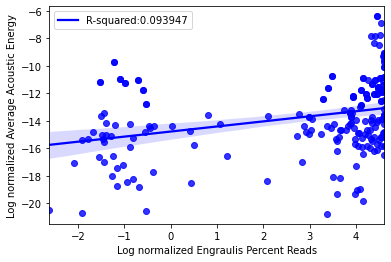

In [136]:
#Everything together

#####   log scale (reads + Ac)
df = eDNA_Ac_comp.copy()
#remove 0 values?
df = df.loc[df['Average sampled energy']>0]
df = df.loc[df['Engraulis']>0]


df['lognorm_avg'] = np.log(df['Average sampled energy'])
df['lognorm_chordata'] = np.log(df['Engraulis'])
df = df.sort_values('lognorm_avg')
df = df.loc[df['lognorm_avg']!=0]
df = df.loc[df['lognorm_avg'].isna()==False]

# get coeffs of linear fit
slope, intercept, r_value, p_value, std_err = stats.linregress(df['lognorm_chordata'],df['lognorm_avg'])
res = stats.linregress(df['lognorm_chordata'],df['lognorm_avg'])
print(f"R-squared: {res.rvalue**2:.6f}")


# use line_kws to set line label for legend
ax = sns.regplot(x="lognorm_chordata", y="lognorm_avg", data=df, color='b', 
 line_kws={'label':f"R-squared:{res.rvalue**2:.6f}"})
# plot legend
ax.legend()

ax.set_xlabel('Log normalized Engraulis Percent Reads')
ax.set_ylabel('Log normalized Average Acoustic Energy')

#save
filename=plot_dir +'CN19S_12S_avgDEIMOS_linres_logavg_everything_comp.pdf'
print(filename)
plt.savefig(filename,dpi=None, facecolor='w', edgecolor='w',
        orientation='landscape', papertype=None, format=None,
        transparent=True, bbox_inches='tight', pad_inches=1,
        frameon=None)

plt.show()


R-squared: 0.158290
../figures/Anchovy_Acoustic/CN19S_12S_avgDEIMOS_linres_logavg_everything_comp.pdf


<ipython-input-137-e0f47d2299be>:34: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "papertype" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(filename,dpi=None, facecolor='w', edgecolor='w',
<ipython-input-137-e0f47d2299be>:34: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(filename,dpi=None, facecolor='w', edgecolor='w',


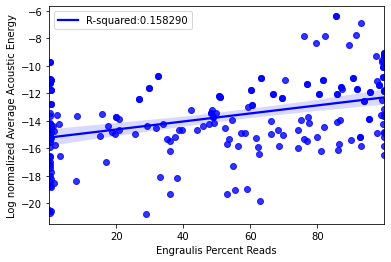

In [137]:
#Everything together

#####   log scale (reads + Ac)
df = eDNA_Ac_comp.copy()
#remove 0 values?
df = df.loc[df['Average sampled energy']>0]
df = df.loc[df['Engraulis']>0]


df['lognorm_avg'] = np.log(df['Average sampled energy'])
df['lognorm_chordata'] = np.log(df['Engraulis'])
df = df.sort_values('lognorm_avg')
df = df.loc[df['lognorm_avg']!=0]
df = df.loc[df['lognorm_avg'].isna()==False]

# get coeffs of linear fit
slope, intercept, r_value, p_value, std_err = stats.linregress(df['Engraulis'],df['lognorm_avg'])
res = stats.linregress(df['Engraulis'],df['lognorm_avg'])
print(f"R-squared: {res.rvalue**2:.6f}")


# use line_kws to set line label for legend
ax = sns.regplot(x="Engraulis", y="lognorm_avg", data=df, color='b', 
 line_kws={'label':f"R-squared:{res.rvalue**2:.6f}"})
# plot legend
ax.legend()

ax.set_xlabel('Engraulis Percent Reads')
ax.set_ylabel('Log normalized Average Acoustic Energy')

#save
filename=plot_dir +'CN19S_12S_avgDEIMOS_linres_logavg_everything_comp.pdf'
print(filename)
plt.savefig(filename,dpi=None, facecolor='w', edgecolor='w',
        orientation='landscape', papertype=None, format=None,
        transparent=True, bbox_inches='tight', pad_inches=1,
        frameon=None)

plt.show()


### Just samples with >10% reads to Anchovy

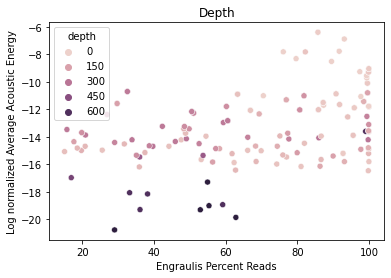

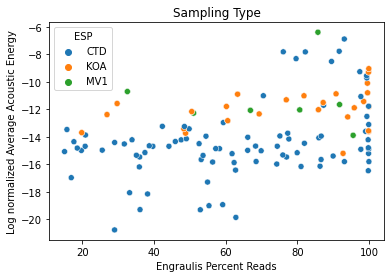

In [145]:
# only samples which detect >1000 reads of Anchovy

#####   log scale (reads + Ac)
df = eDNA_Ac_comp.copy()
#remove 0 values?
df = df.loc[df['Average sampled energy']>0]
df = df.loc[df['Engraulis']>=10]
#df = df.loc[df['depth']<100]

df['lognorm_avg'] = np.log(df['Average sampled energy'])
#df['lognorm_chordata'] = np.log(df['Engraulis'])
df = df.sort_values('lognorm_avg')
df = df.loc[df['lognorm_avg']!=0]
df = df.loc[df['lognorm_avg'].isna()==False]

ax = sns.scatterplot(data=df,x="Engraulis", y="lognorm_avg",hue='depth' )
ax.set_xlabel('Engraulis Percent Reads')
ax.set_ylabel('Log normalized Average Acoustic Energy')
ax.set_title('Depth')
plt.show()
df = df.reset_index()
df.loc[df['ESP'].isna()==True, 'ESP'] = 'CTD'
ax = sns.scatterplot(data=df,x="Engraulis", y="lognorm_avg",hue='ESP' )
ax.set_xlabel('Engraulis Percent Reads')
ax.set_ylabel('Log normalized Average Acoustic Energy')
ax.set_title('Sampling Type')
plt.show()


R-squared: 0.150544
../figures/Anchovy_Acoustic/CN19S_12S_avgDEIMOS_linres_logavg_1000readsAnch_comp.pdf


<ipython-input-146-9bef33c2d4f5>:32: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "papertype" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(filename,dpi=None, facecolor='w', edgecolor='w',
<ipython-input-146-9bef33c2d4f5>:32: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(filename,dpi=None, facecolor='w', edgecolor='w',


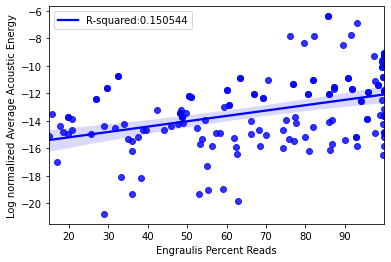

In [146]:
#####   log scale (reads + Ac)
df = eDNA_Ac_comp.copy()
#remove 0 values?
df = df.loc[df['Average sampled energy']>0]
df = df.loc[df['Engraulis']>=10]
#df = df.loc[df['depth']<100]

df['lognorm_avg'] = np.log(df['Average sampled energy'])
#df['lognorm_chordata'] = np.log(df['Engraulis'])
df = df.sort_values('lognorm_avg')
df = df.loc[df['lognorm_avg']!=0]
df = df.loc[df['lognorm_avg'].isna()==False]

# get coeffs of linear fit
slope, intercept, r_value, p_value, std_err = stats.linregress(df['Engraulis'],df['lognorm_avg'])
res = stats.linregress(df['Engraulis'],df['lognorm_avg'])
print(f"R-squared: {res.rvalue**2:.6f}")


# use line_kws to set line label for legend
ax = sns.regplot(x="Engraulis", y="lognorm_avg", data=df, color='b', 
 line_kws={'label':f"R-squared:{res.rvalue**2:.6f}"})
# plot legend
ax.legend()

ax.set_xlabel('Engraulis Percent Reads')
ax.set_ylabel('Log normalized Average Acoustic Energy')

#save
filename=plot_dir +'CN19S_12S_avgDEIMOS_linres_logavg_1000readsAnch_comp.pdf'
print(filename)
plt.savefig(filename,dpi=None, facecolor='w', edgecolor='w',
        orientation='landscape', papertype=None, format=None,
        transparent=True, bbox_inches='tight', pad_inches=1,
        frameon=None)

plt.show()